# View rendering (considering an agent)
This notebook explores the scenarios for our `agentic` image-rendering: to initialize and align our visual and semantic encoders we let the agent to explore the documents in a free-run `pretraining` session. We consider using [some reinforcement-learning](RL-Env-Setup.ipynb) down the road.

* [visual observation](#render)
* [action-space](#act)
* [context](#context)
* [non-doc examples](#nondoc)


In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib as mpl

from pathlib import Path
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from matplotlib import patches
#from sklearn.neighbors import KDTree
from IPython.display import display, clear_output
from elasticsearch import Elasticsearch

In [2]:
# local scripts lib
from scripts import simulate as sim
from scripts import parse

Documents are indexed -- we can query their layout/content.

In [3]:
INDEX = 'doc-pages'

eclient = Elasticsearch(
    hosts=[os.environ['ELASTIC_URI']],
    basic_auth=('elastic', os.environ['ELASTIC_PASSWORD']),
    verify_certs=False
)

def get_page_content(doc, page, size=10000):
    query = {'bool': {'must': [{'match': {'doc_id': doc }}, {'match': {'page_id': page }}]}}
    sort = [{'top': {'order': 'asc'}}, {'left': {'order': 'asc'}}]
    return [x['_source'] for x in eclient.search(index=INDEX, query=query, sort=sort, size=size)['hits']['hits']]

BOX = ['top','left','bottom','right']

In [4]:
# page-images extracted from interactive pdfs with inputs info
images = [str(x) for x in Path('./data/images').glob('*.png') if not str(x).startswith('data/images/que-')]
len(images)

8974

In [5]:
VIEW_SIZE = 224

<a name="render"></a>

### Renderer for agent's view
Let's define the rendering utility for the agent's view.

In [6]:
class Renderer:
    def __init__(self, channels: int = 1, bias: int = 0):
        self.bias = bias   # background
        self.channels = channels
    
    def render(self, radius: int) -> np.array:
        # square bounding box for a circle reception around a view center
        radius = max(0, radius)
        size = 2 * radius
        view = (np.zeros((size, size, self.channels)) + self.bias).astype(np.uint8)
        return view


class ImageSpace(Renderer):
    def __init__(self, image: np.array, bias: int = 0):
        if len(image.shape) == 2:
            image = image[..., np.newaxis]
        super(ImageSpace, self).__init__(channels=image.shape[2], bias=bias)
        self.image = image[:,:,:]
        self.H, self.W, self.C = image.shape
        # relative units to measure transitions
        self.norm = np.array([max(self.H, self.W)] * 2 + [180, 1]).astype(np.float32)
    
    @property
    def center(self):
        return self.H//2, self.W//2
                
    # clip of background image which appears in the view ( could be nothing -- plain background )
    def render(self, center: tuple, radius: int) -> np.array:
        view = super().render(radius) # plain background
        dh, dw = center
        # image-matrix indices
        t, l = max(dh - radius, 0), max(dw - radius, 0)
        if t >= self.H or l >= self.W:
            return view
        b, r = min(dh + radius, self.H), min(dw + radius, self.W)
        if b <= t or r <= l:
            return view        
        self._loc = (t, b, l, r)
        clip = self.image[t:b,l:r,:]
        # view-matrix indices
        t, l = abs(min(dh - radius, 0)), abs(min(dw - radius, 0)) # top, left
        b, r = t + clip.shape[0], l + clip.shape[1]  # bottom, right
        view[t:b,l:r,:] = clip[:,:,:]
        return view
 

In [7]:
#source = np.random.choice(images)
source = 'data/images/irs-f8825-1.png'
image = np.array(ImageOps.grayscale(Image.open(source)))

mn, mx = np.min(image), np.max(image)
image = (255 - (image - mn)/(mx - mn) * 255).astype(np.uint8)

space = ImageSpace(image)
source, space.center

('data/images/irs-f8825-1.png', (1100, 850))

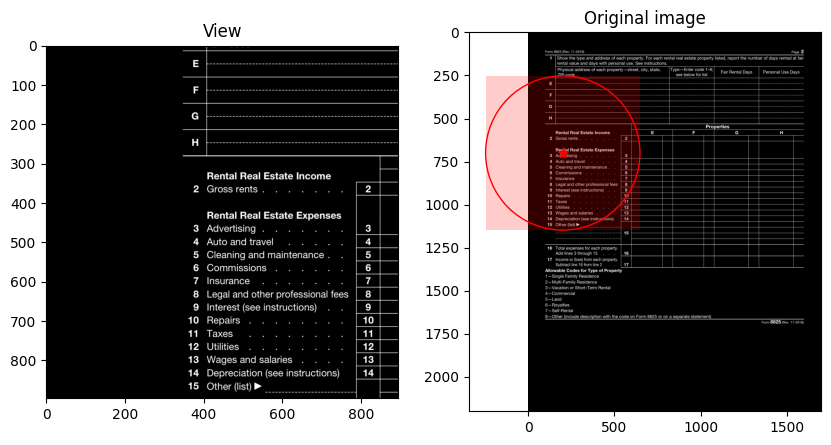

In [8]:
h, w, r = 700, 200, 448

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(space.render((h, w), r), 'gray')
ax[0].set_title('View')
ax[1].imshow(image, 'gray')
ax[1].scatter([w],[h], marker='*', color='r', s=50)
ax[1].add_patch(patches.Rectangle((w - r, h - r), r * 2, r * 2,
                                  linewidth=0, edgecolor='none', facecolor='r', alpha=0.2))
ax[1].add_patch(patches.Circle((w, h), r, linewidth=1, edgecolor='r', facecolor='none'))
ax[1].set_title('Original image')
plt.show()

<a name="act"></a>

### Action space
Agent can move the view center, and zoom in and out. Agent cannot change view resolution -- it is always the same `VIEW_SIZE`.

In [9]:
class AgentView:    
    def __init__(self, image: np.array, dim: int, bias: int = 0, zoom_range: tuple = (-5, 1)):
        # sets the exploration space
        self.space = ImageSpace(image, bias=bias) #np.quantile(image, 0.25)
        # sets the agent's view resolution
        self.dim = dim
        self.channels = self.space.C
        # limit zoom to avoid overload
        self.zoom_range = tuple(sorted(zoom_range))
        # initialised the agent's state tracking: default top-left corner
        self._state = np.zeros((4,))
    
    def set_state(self, center: tuple, rotation: float = 0., zoom: float = 0.) -> np.array:
        if zoom > self.zoom_range[1] or zoom < self.zoom_range[0]:
            #print(f'WARNING: zoom value is clipped to range {self.zoom_range} relative to the page top-view')
            zoom = np.clip(zoom, *self.zoom_range)
        rotation = self.get_angle(rotation)
        self._state = np.array(list(center) + [rotation, zoom])
        return self.render(center, rotation, zoom)
                        
    @property
    def state(self):
        return self._state[:]
        
    @staticmethod
    def get_angle(rotation: float = 0.) -> float:
        """
        map into [0, 360] interval
        """
        rotation = rotation % 360
        if rotation >= 0:
            return rotation
        return 360 + rotation
    
    def get_size(self, zoom: float = 0.) -> int:
        """
        size of the actual image clip in the view
        """
        if zoom == 0.:
            return self.dim
        return int(np.round(self.dim * (2 ** -zoom)))
    
    def get_zoom(self) -> tuple:
        """
        bird's-eye view zoom-value
        """
        return -np.log2(max(self.space.W, self.space.H) / self.dim)
    
    def top(self):
        """
        render bird's-eye view: fit the whole image into a view-frame
        """
        return self.set_state(self.space.center, 0, self.get_zoom())
    
    def isin(self) -> bool:
        """
        at least some part of the doc is present in the view vs nothing at all
        """
        radius = self.get_size(self._state[-1])
        distance = np.linalg.norm(np.array(self.space.center) - self._state[:2])
        if distance - radius > max(self.space.center):
            return False
        return abs(self._state[0] - self.space.center[0]) < radius + self.space.center[0] and \
                abs(self._state[1] - self.space.center[1]) < radius + self.space.center[1]
        
    
    def render(self, center: tuple, rotation: float = 0., zoom: float = 0.) -> np.array:
        """
        generate a view relative to the page origin (absolute)
        """
        if zoom > self.zoom_range[1] or zoom < self.zoom_range[0]:
            print(f'Zoom value is clipped to range {self.zoom_range} relative to the page origin')
            zoom = np.clip(zoom, *self.zoom_range)
        size = self.get_size(zoom)
        radius = size//2
        h, w = center
        angle = self.get_angle(rotation)
        if angle == 0:
            view = self.space.render(center, radius)           
        else: # rotate
            # make room for rotation without expand
            diag = int(np.ceil(radius * np.sqrt(2)))
            view = self.space.render(center, diag)
            view = np.array(Image.fromarray(view.squeeze()).rotate(angle, expand=False))
            # crop margins back to `size`
            view = view[ diag - radius : radius - diag, diag - radius : radius - diag]
        if size == self.dim:
            return view
        # resample to match view dim
        view = np.array(Image.fromarray(view.squeeze().astype(np.uint8)).resize((self.dim, self.dim)))
        return view.reshape((self.dim, self.dim, self.channels))
    
    def translate_action(self, action):
        """
        action defined by 4 values between -1 and 1 -- relative and normalized
        translate (denormalize) it into absolute units -- w/h pixels and rotation degrees
        """
        value = action * self.space.norm
        value[:2] = np.round(value[:2])
        value[2] = self.get_angle(value[2])
        return value
    
    def transform(self, action):
        """
        reset the state by action value and generate resulting view
        """
        action = np.clip(action, -1., 1.)
        state = self.state + self.translate_action(action)
        return self.set_state(state[:2].astype(int), state[2], state[3])
        
        # apply rotation matrix to get relative transition
        #state = self.state + self.translate_action(action)
        #alpha = np.pi * self.state[2] / 180.
        #h, w = self.state[:2]
        #dh, dw = state[:2]
        #w += dh * np.sin(alpha) + dw * np.cos(alpha)
        #h += dw * np.sin(alpha) + dh * np.cos(alpha)
        #center = (int(h), int(w))
        #return self.set_state(center, state[2], state[3])
    

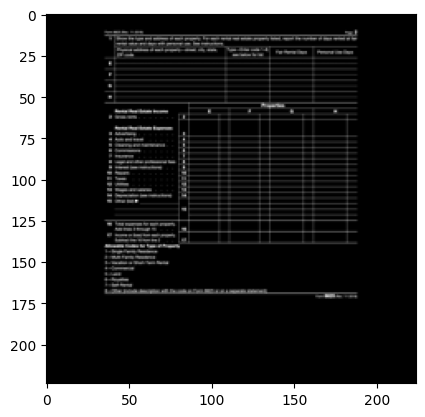

In [10]:
nav = AgentView(image, VIEW_SIZE)

# bring the whole page in the focus
plt.imshow(nav.top(), 'gray')
plt.show()

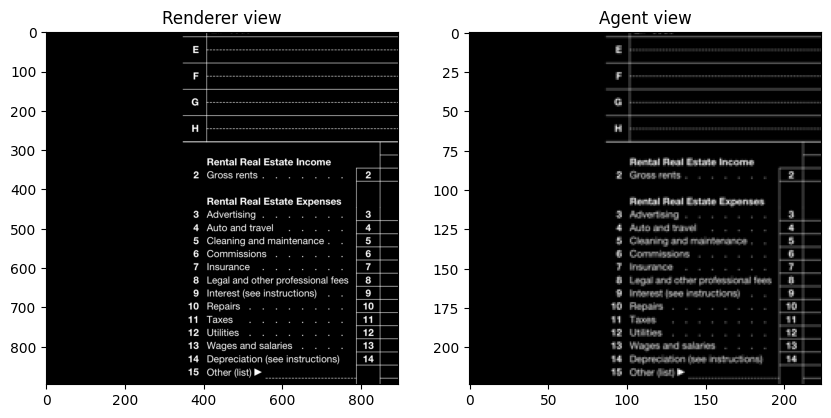

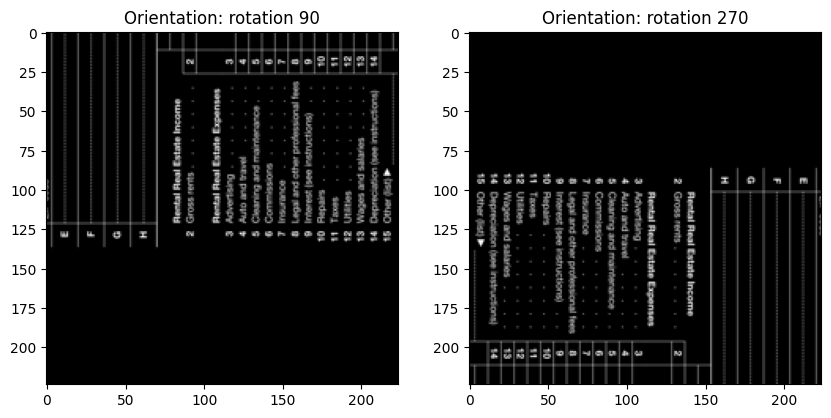

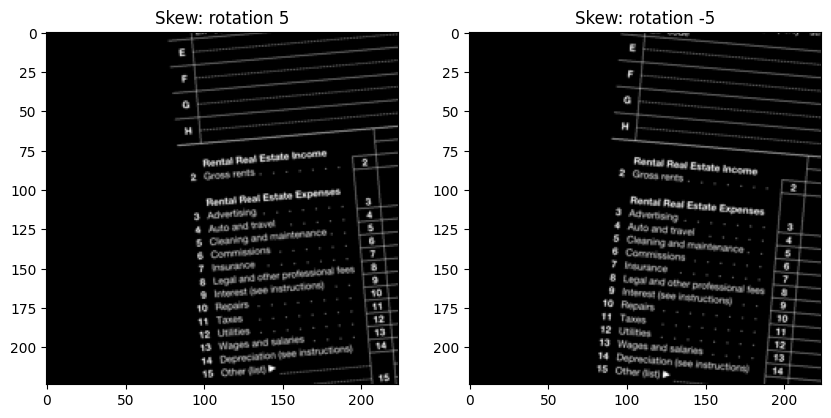

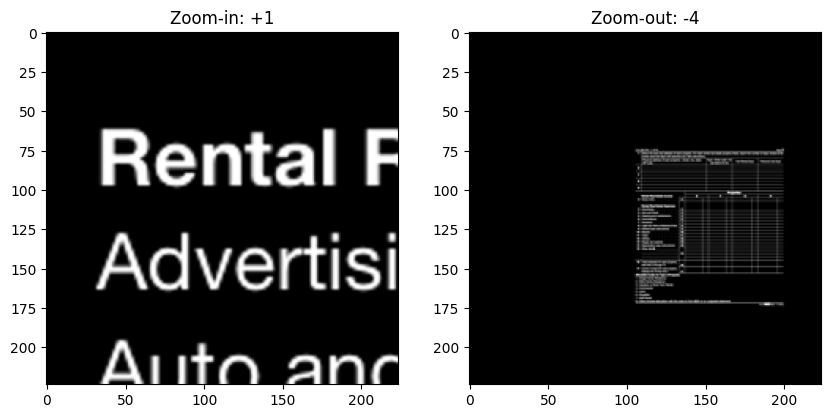

In [11]:
nav = AgentView(image, VIEW_SIZE)

# generate few "conceptual" examples
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(space.render((h, w), r), 'gray')
ax[0].set_title('Renderer view')
ax[1].imshow(nav.render((h, w), 0, -2), 'gray')
ax[1].set_title('Agent view')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(nav.render((h, w), 90, -2), 'gray')
ax[0].set_title('Orientation: rotation 90')
ax[1].imshow(nav.render((h, w), 270, -2), 'gray')
ax[1].set_title('Orientation: rotation 270')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(nav.render((h, w), 5, -2), 'gray')
ax[0].set_title('Skew: rotation 5')
ax[1].imshow(nav.render((h, w), -5, -2), 'gray')
ax[1].set_title('Skew: rotation -5')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(nav.render((h, w), 0, 1), 'gray')
ax[0].set_title('Zoom-in: +1')
ax[1].imshow(nav.render((h, w), 0, -4), 'gray')
ax[1].set_title('Zoom-out: -4')
plt.show()

In [12]:
def show_movie(sequence):
    """
    show animated visual for a sequence of actions
    """
    for action in sequence:
        observation = nav.transform(action)
        img = plt.imshow(observation, 'gray')
        plt.title(f' Action:{action}', ha='left', x=0, fontdict={'family':'monospace','size':10})
        display(plt.gcf())
        clear_output(wait=True)
        

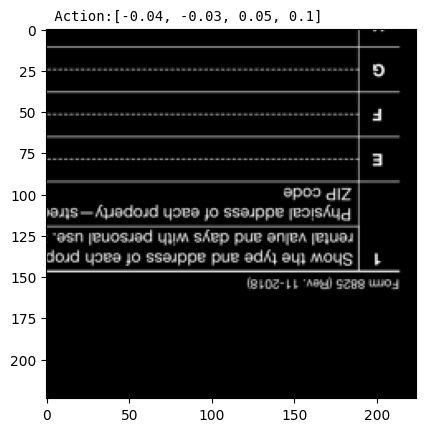

In [13]:
nav = AgentView(image, VIEW_SIZE)
view = nav.top()

sequence = [[-0.04, -0.03, 0.05, 0.1] for _ in range(20)]
show_movie(sequence)

<a name="context"></a>

### Context: semantic space
We start with a minimal set of concepts the agent needs to "understand": `skew`, `orientation`, `text`, `input`, `table`, `noise`, `non-doc`.
Let's generate some visual masks for training and estimate class-weights.

In [14]:
# priority order: first overrides following in argmax
ORDER = ['void','line','input','word']

def build_mask(image: np.array, source: str) -> np.array:
    """
    create class-indices matrix (classes are xclusive)
    """
    # extract outlines
    lines = parse.extract_lines(image, units=20)
    h, w = image.shape
    mask = np.zeros((h, w, len(ORDER)))            
    mask[:,:,ORDER.index('line')] = lines
    # load page data
    doc = source.split('/').pop()[:-4].split('-')
    doc, page = '-'.join(doc[:-1]), int(doc[-1])
    data = get_page_content(doc, page)
    if len(data) == 0:
        return None #mask
    data = pd.DataFrame.from_dict(data)
    data.loc[:,BOX] = np.round(data[BOX] * min((h, w))).astype(int)
    for t,l,b,r in data[data['block_type']=='word'][BOX].values:
        # reduce space between neighbor words
        mask[int(t):int(b), int(l) - 1:int(r) + 2, ORDER.index('word')] = 1
    for t,l,b,r in data[data['block_type']=='input'][BOX].values:
        # increase space between neighbor inputs
        mask[int(t) + 3:int(b) - 2, int(l) + 1:int(r), ORDER.index('input')] = 1
    # convert to indices
    return np.argmax(mask, axis=(2))


In [15]:
# load original page image -- ground truth
orig = np.array(ImageOps.grayscale(Image.open(source)))
h, w = orig.shape
# build 3-channel segmentation mask
mask = build_mask(orig, source)

# make noisy version
noise = sim.generate_noise(max(w, h), light_bias=0.5, noise_strength=0.5)[:h,:w]
noisy, noise = orig / 255. * (0.5 + noise * 0.5), None

# normalize and invert
mn, mx = np.min(orig), np.max(orig)
orig = 1 - (orig - mn)/(mx - mn)
mn, mx = np.min(noisy), np.max(noisy)
noisy = 1 - (noisy - mn)/(mx - mn)

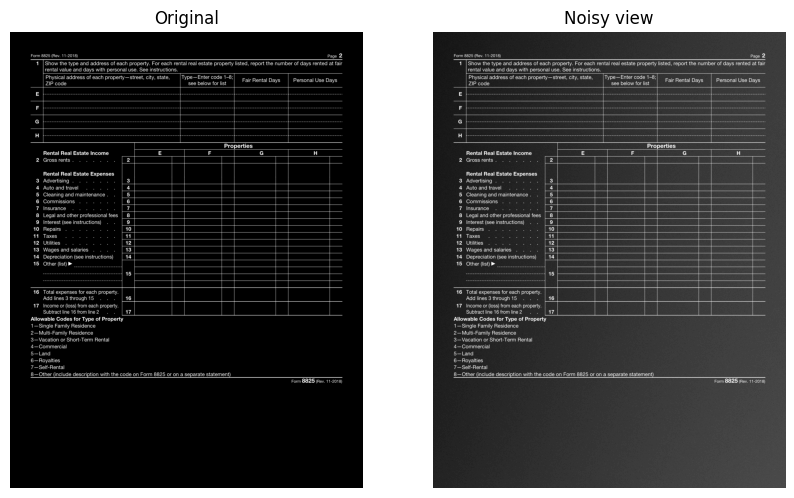

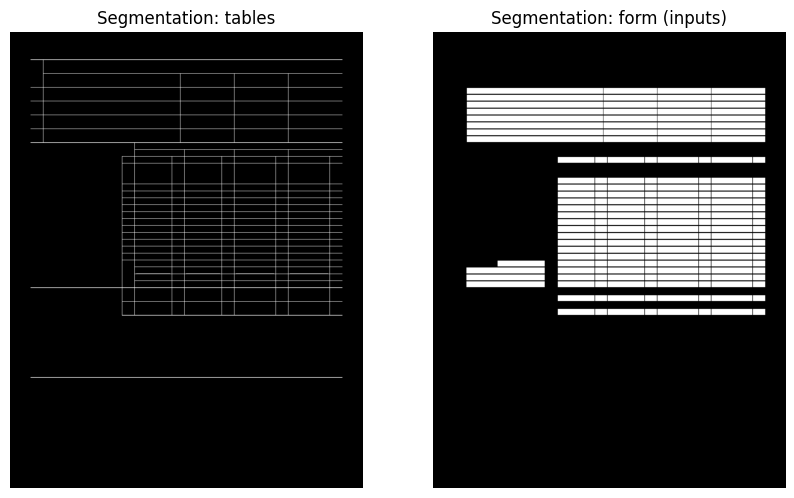

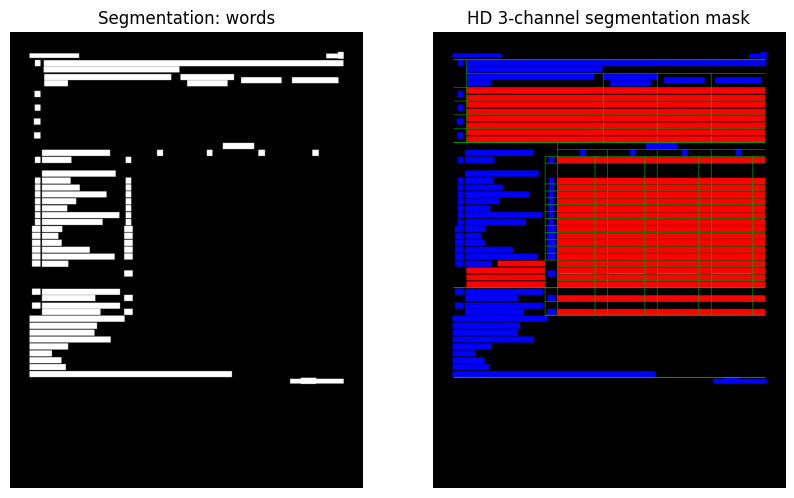

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(orig, 'gray')
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(noisy, 'gray')
ax[1].set_title('Noisy view')
ax[1].axis('off')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow((mask == ORDER.index('line')).astype(int), 'gray')
ax[0].set_title('Segmentation: tables')
ax[0].axis('off')
ax[1].imshow((mask == ORDER.index('input')).astype(int), 'gray')
ax[1].set_title('Segmentation: form (inputs)')
ax[1].axis('off')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow((mask == ORDER.index('word')).astype(int), 'gray')
ax[0].set_title('Segmentation: words')
ax[0].axis('off')
# restore channels
matrix = (np.eye(len(ORDER))[mask][:,:,1:] > 0) * 255
# til -> ilt change RGB order for the best visibility (depends on the monitor)
ax[1].imshow(matrix[:,:,[1,0,2]])
ax[1].set_title('HD 3-channel segmentation mask')
ax[1].axis('off')
plt.show()

To speed up our dataloader we prepare masks upfront and save them as images to save space.
We also need to know class-weights to help with unbalanced representation (empty space is dominating).

In [17]:
    #!mkdir data/masks
    !rm -rf data/masks/*
    nodata, stats, counts = [], np.zeros((4,)), np.zeros((2,))
    # generate masks for all images
    for i, source in enumerate(images, 1):
        # load original page image -- ground truth
        orig = np.array(ImageOps.grayscale(Image.open(source)))
        h, w = orig.shape
        # build 3-channel segmentation mask
        mask = build_mask(orig, source)
        if mask is None:
            nodata.append(source)
            continue
        stats += np.histogram(mask, bins=4)[0] * 1e-6
        orig = (255 - orig).astype(float)
        orig -= np.min(orig)
        orig /= (np.max(orig) or 1.)
        v = np.sum(orig >= 0.25)
        counts += np.array([h * w - v, v]) * 1e-6
        Image.fromarray(mask.astype(np.uint8)).save(f"./data/masks/{source.split('/').pop()}")
        print(f'done: {(i)/len(images):.2%}  skipped {len(nodata)/i:.2%} due to missing data', end='\r')
    stats /= i
    counts /= i

In [18]:
#Image.open(f"data/masks/{source.split('/').pop()}")

In [19]:
# compute class-weights for training
segmentation_weight = np.array([1/x for x in stats])
np.round(segmentation_weight/sum(segmentation_weight), 4)

array([0.0185, 0.7981, 0.1381, 0.0453])

In [20]:
# compute class-weights for training
denoising_weight = np.array([1/x for x in counts])
np.round(denoising_weight/sum(denoising_weight), 4)

array([0.0713, 0.9287])

<a name="nondoc"></a>

### Out-of-Class examples
For this purpose we can download some images from `Unsplash` where no text is present anywhere, resize to manageable size and save as graiscale.

In [21]:
# random images from unsplash for out-of-class examples
nondocs = [str(x) for x in Path(f'./data/unsplash').glob('*.jpg')]

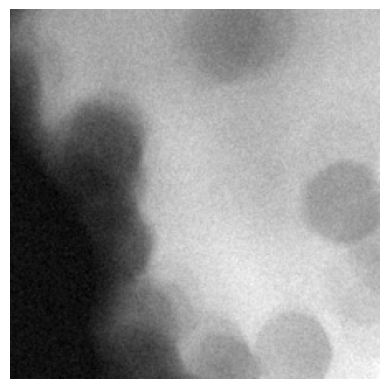

In [23]:
def make_negative_sample(view_size):
    """
    generate random non-document view
    """
    sample = 255 - np.array(ImageOps.grayscale(Image.open(np.random.choice(nondocs))))
    nav = AgentView(sample, view_size)
    center = (np.array(sample.shape) * (1 - np.random.rand(2))).astype(int)
    rotation = np.random.randint(0, 360)
    zoom = np.random.rand() * 2 - 2
    return nav.render(center, rotation, zoom)

plt.imshow(make_negative_sample(VIEW_SIZE), 'gray')
plt.axis('off')
plt.show()